In [1]:
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')
import cv2
import os
import re
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Preprocessing the data

In [4]:
#open the zip file
with ZipFile('fruits5.zip', 'r') as zip_fruits:
    list_fruits = zip_fruits.namelist()

In [5]:
#Drop the ReadME File, drop the first 32.
fruit5 = pd.DataFrame(list_fruits[33:], columns = ['path_fruit']) 
fruit5 = fruit5[fruit5.index%2==1]

In [6]:
#test set
test_fruit5 = []
for path_fruit in fruit5['path_fruit']:
    if 'test' in path_fruit: 
            test_fruit5.append(path_fruit)
test_fruit5 = pd.DataFrame(test_fruit5, columns = ['path_fruit'])

In [7]:
#train set
train_fruit5 = []
for path_fruit in fruit5['path_fruit']:
    if 'train' in path_fruit: 
            train_fruit5.append(path_fruit)
train_fruit5 = pd.DataFrame(train_fruit5, columns = ['path_fruit'])

In [8]:
#Conduct regrex, and add label to the data
l = []
for i in train_fruit5['path_fruit']:
    l.append(re.findall("train/(nt|[a-zA-Z\s+]+)", i)[0])
train_fruit5['label'] = l

l2 = []
for i in test_fruit5['path_fruit']:
    l2.append(re.findall("test/(nt|[a-zA-Z\s+]+)", i)[0])
test_fruit5['label'] = l2

In [9]:
#Put image into several feasures
fruit_images = []
label2 = [] 
for i in range(len(train_fruit5)):
    images = cv2.imread(train_fruit5['path_fruit'][i], cv2.IMREAD_COLOR)
    images = cv2.resize(images, (60, 60))
    images = cv2.cvtColor(images, cv2.COLOR_RGB2BGR)   
    label2.append(train_fruit5['label'][i])
    fruit_images.append(images)


label2 = np.array(label2)
label2_enum = {j:i for i,j in enumerate(np.unique(label2))}
label_ids = np.array([label2_enum[i] for i in label2])
    
fruit_images = np.array(fruit_images)

## PCA

In [10]:
#Scaling
scaler = StandardScaler()
scale_images = scaler.fit_transform([i.flatten() for i in fruit_images])

In [11]:
#fit the model
pca = PCA().fit(scale_images)

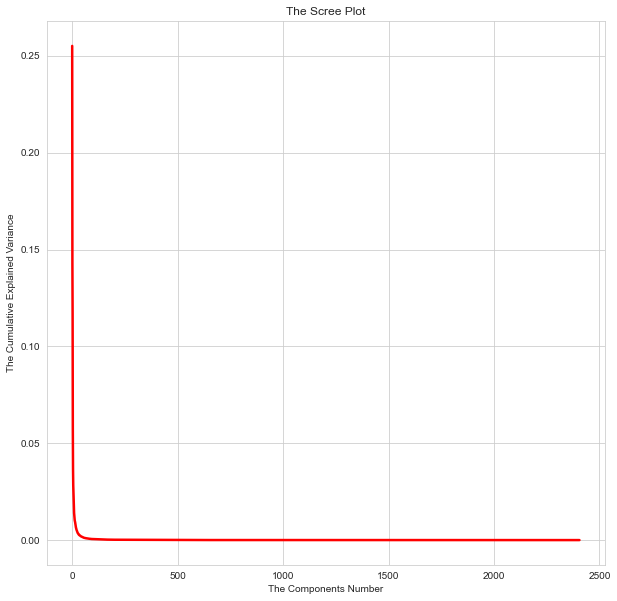

In [12]:
#scree plot for entire traiing set of images
sns.set_style("whitegrid")
plt.figure(figsize = (10,10))
plt.plot(pca.explained_variance_ratio_, color = 'red', linewidth = 2.5)
plt.xlabel('The Components Number')
plt.ylabel('The Cumulative Explained Variance')
plt.title('The Scree Plot')
plt.show()

In [13]:
explained_var = list(pca.explained_variance_ratio_)
shifted_var = explained_var
var_df = DataFrame()
var_df['explained_var'] = explained_var
var_df['shifted_var'] = shifted_var
var_df['shifted_var'] = var_df['shifted_var'].shift(-1)
var_df['shifted_var'].fillna(0)
var_df['difference'] = var_df['explained_var'] - var_df['shifted_var']
v = var_df[var_df['difference'] < .00004].reset_index()
v = v.rename(columns={'index': 'components'})
v.iloc[4]

components       52.000000
explained_var     0.001378
shifted_var       0.001345
difference        0.000032
Name: 4, dtype: float64

In [14]:
sample_pca = train_fruit5.sample(n = 25, replace=True, random_state=2020).reset_index(drop = True)

In [15]:
images_sample = []
labels_sample = [] 
for i in range(len(sample_pca)):
    images = cv2.imread(sample_pca['path_fruit'][i], cv2.IMREAD_COLOR)
    images = cv2.resize(images, (60, 60))
    images = cv2.cvtColor(images, cv2.COLOR_RGB2BGR)    
    labels_sample.append(sample_pca['label'][i]) 
    images_sample.append(images)

images_sample = np.array(images_sample)

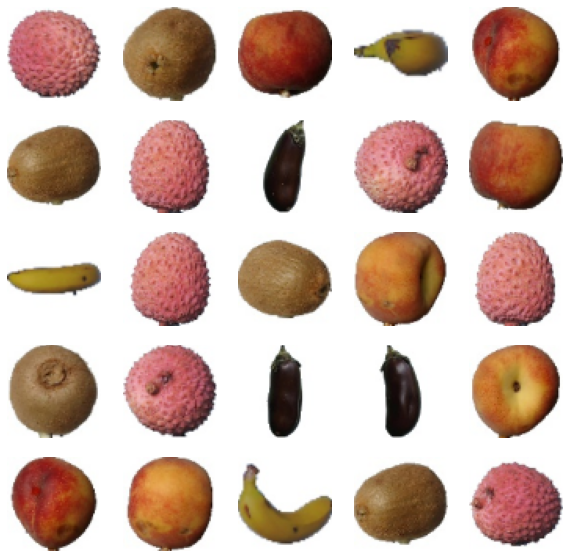

In [16]:
fig, axes = plt.subplots(5,5, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    ax.axis('off')
    ax.imshow(images_sample[i])

In [17]:
sample_path = sample_pca['path_fruit']
sample_fruits = pd.DataFrame([])
for x in sample_path:
    images = mean(mpimg.imread(x), 2)
    sample = pd.Series(images.flatten(), name=x)
    sample_fruits = sample_fruits.append(sample)

In [18]:
ld_fruit = pca.fit_transform(sample_fruits)
ld_fruit_inv = pca.inverse_transform(ld_fruit)

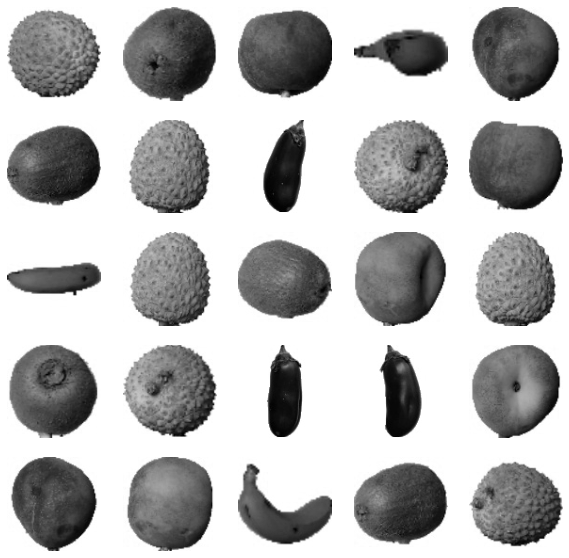

In [19]:
fig, axes = plt.subplots(5,5, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    ax.axis('off')
    ax.imshow(ld_fruit_inv[i].reshape(100,100), cmap = 'gray')

## TSNE

In [20]:
pca = PCA(n_components=5)
result_pca5 = pca.fit_transform(scale_images)

In [21]:
tsne = TSNE(n_components=2, perplexity=40.0)
result_tsne2 = tsne.fit_transform(result_pca5)
result_tsne2_scaled = StandardScaler().fit_transform(result_tsne2)

In [22]:
df_tsne = DataFrame()
df_tsne['x'] = list(result_tsne2_scaled[:,0])
df_tsne['y'] = list(result_tsne2_scaled[:,1])
df_tsne['label'] = label2
df_tsne[100:150]

,x,y,label
100,-0.022459,-1.408350,Kiwi
101,0.346933,-0.422643,Kiwi
102,0.454605,-1.535551,Kiwi
103,0.450991,-0.467195,Kiwi
104,0.326170,-1.467470,Kiwi
105,0.824232,-0.193681,Kiwi
106,0.525342,-0.408463,Kiwi
107,0.483136,-1.608956,Kiwi
108,0.609802,-0.398473,Kiwi
109,0.346058,-1.628621,Kiwi


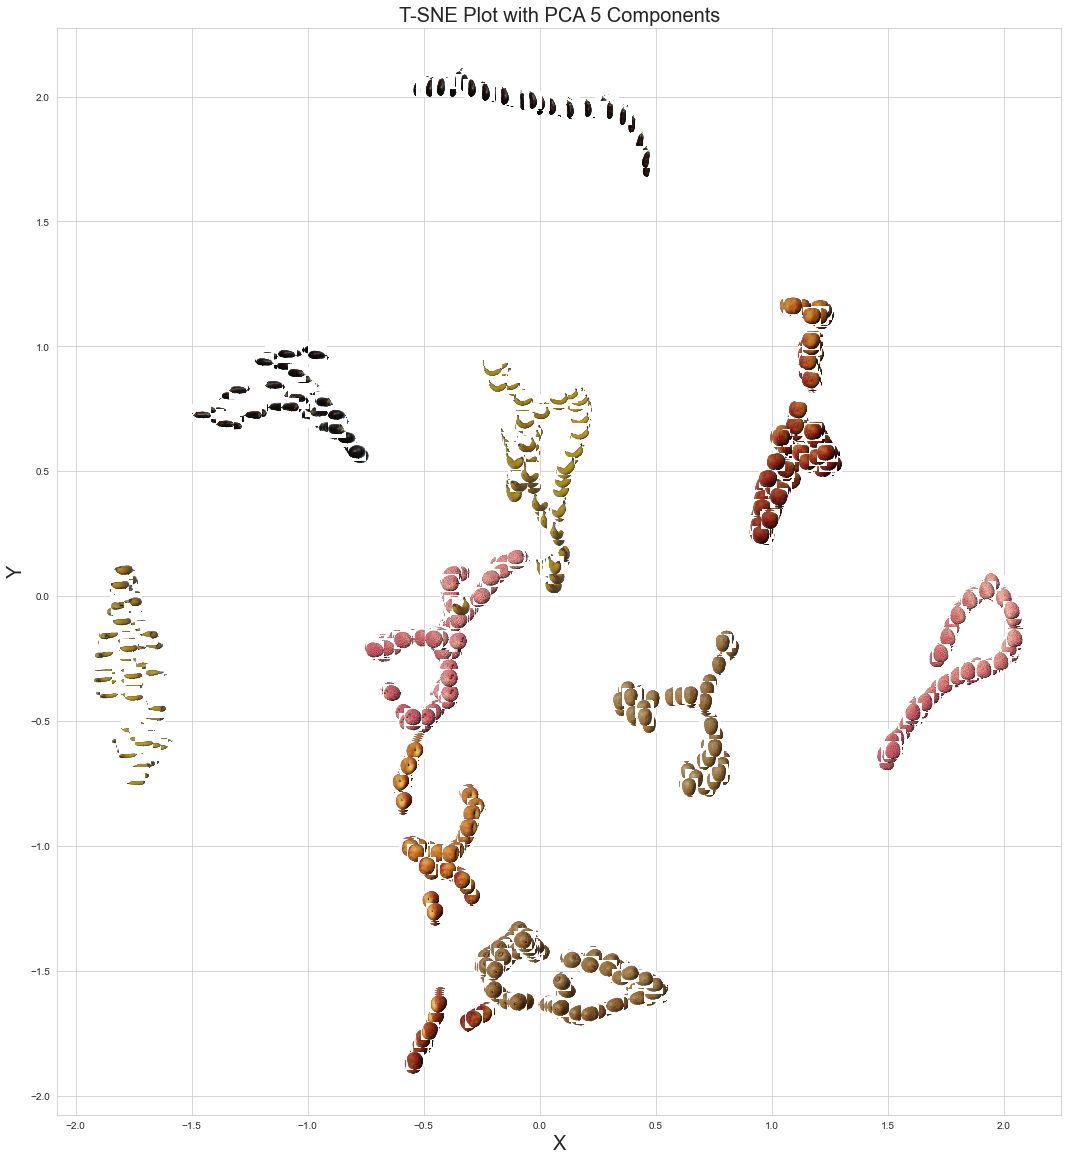

In [23]:
fig, ax = plt.subplots(figsize=(18,20))
for d, i in zip(df_tsne.iterrows(), fruit_images):
    x = d[1]['x']
    y = d[1]['y']
    images = OffsetImage(i, zoom = .3)
    AnnBox = AnnotationBbox(images, (x,y), xycoords = 'data', frameon = False)
    ax.add_artist(AnnBox)
ax.update_datalim(df_tsne[['x', 'y']].values)
ax.autoscale()
plt.xlabel('X', fontsize = 20)
plt.ylabel('Y', fontsize = 20)
plt.title('T-SNE Plot with PCA 5 Components', fontsize = 20)
plt.show()

## KNN

In [24]:
df_pca = DataFrame()
for i in range(5):
    df_pca[i] = result_pca5[:,i]

In [25]:
df_pca.head()

,0,1,2,3,4
0,2.346023,-17.027757,5.388979,17.280958,24.723449
1,21.126804,18.244055,-6.772463,-39.352525,25.077338
2,-0.206889,-15.198398,6.908538,15.674459,25.634075
3,18.980795,18.845791,-5.741021,-39.253590,26.366545
4,49.310590,0.315455,8.958577,-8.933227,14.567210


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_pca, label_ids, test_size=0.40, random_state=42)

In [56]:
accuracy = []
for i in range(1, 50, 1):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

In [57]:
df_accuracy = DataFrame()
df_accuracy['k'] = range(1,50, 1)
df_accuracy['accuracy'] = accuracy
df_accuracy['accuracy_shift'] = df_accuracy['accuracy'].shift(-1)
df_accuracy['accuracy_shift'].fillna(0, inplace = True)
df_accuracy['difference'] = df_accuracy['accuracy'] - df_accuracy['accuracy_shift']

In [58]:
df_accuracy

,k,accuracy,accuracy_shift,difference
0,1,0.976456,0.971499,0.004957
1,2,0.971499,0.973978,-0.002478
2,3,0.973978,0.973978,0.000000
3,4,0.973978,0.973978,0.000000
4,5,0.973978,0.973978,0.000000
5,6,0.973978,0.975217,-0.001239
6,7,0.975217,0.973978,0.001239
7,8,0.973978,0.975217,-0.001239
8,9,0.975217,0.975217,0.000000
9,10,0.975217,0.975217,0.000000


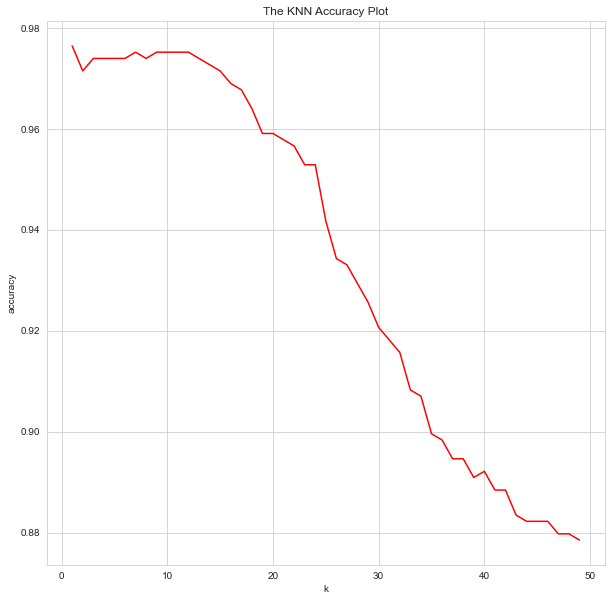

In [59]:
sns.set_style("whitegrid")
plt.figure(figsize = (10,10))
ax = sns.lineplot(x="k", y="accuracy", color = 'red', data=df_accuracy)
ax.set_title('The KNN Accuracy Plot')
plt.show()

## Decision Tree

In [60]:
accuracy2 = []
for i in range(1,50, 1):
    dtree = DecisionTreeClassifier(max_depth = i)
    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)
    accuracy2.append(accuracy_score(y_test, y_pred))

In [61]:
df_accuracy2 = DataFrame()
df_accuracy2['max_depth'] = range(1,50, 1)
df_accuracy2['accuracy'] = accuracy2
df_accuracy2['accuracy_shift'] = df_accuracy2['accuracy'].shift(-1)
df_accuracy2['accuracy_shift'].fillna(0, inplace = True)
df_accuracy2['difference'] = df_accuracy2['accuracy'] - df_accuracy2['accuracy_shift']

In [62]:
df_accuracy2

,max_depth,accuracy,accuracy_shift,difference
0,1,0.408922,0.629492,-0.220570
1,2,0.629492,0.827757,-0.198265
2,3,0.827757,0.864932,-0.037175
3,4,0.864932,0.874845,-0.009913
4,5,0.874845,0.853779,0.021066
5,6,0.853779,0.877323,-0.023544
6,7,0.877323,0.855019,0.022305
7,8,0.855019,0.882280,-0.027261
8,9,0.882280,0.881041,0.001239
9,10,0.881041,0.877323,0.003717


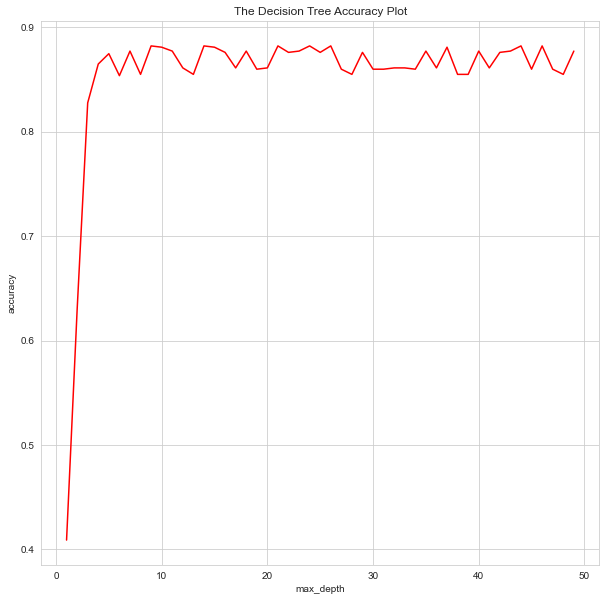

In [63]:
sns.set_style("whitegrid")
plt.figure(figsize = (10, 10))
ax = sns.lineplot(x="max_depth", y="accuracy", color = 'red', data=df_accuracy2)
ax.set_title('The Decision Tree Accuracy Plot')
plt.show()

## Random Forest

In [64]:
accuracy2 = []
for i in range(1,50, 1):
    rf = RandomForestClassifier(n_estimators=100, max_depth=i, random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    accuracy2.append(accuracy_score(y_test, y_pred))

In [65]:
df_accuracy3 = DataFrame()
df_accuracy3['max_depth'] = range(1,50, 1)
df_accuracy3['accuracy'] = accuracy2
df_accuracy3['accuracy_shift'] = df_accuracy3['accuracy'].shift(-1)
df_accuracy3['accuracy_shift'].fillna(0, inplace = True)
df_accuracy3['difference'] = df_accuracy3['accuracy'] - df_accuracy3['accuracy_shift']
df_accuracy3[df_accuracy3['difference'] == 0].iloc[0]
df_accuracy3

,max_depth,accuracy,accuracy_shift,difference
0,1,0.767038,0.776952,-0.009913
1,2,0.776952,0.801735,-0.024783
2,3,0.801735,0.861214,-0.059480
3,4,0.861214,0.898389,-0.037175
4,5,0.898389,0.907063,-0.008674
5,6,0.907063,0.915737,-0.008674
6,7,0.915737,0.919455,-0.003717
7,8,0.919455,0.923172,-0.003717
8,9,0.923172,0.916976,0.006196
9,10,0.916976,0.920694,-0.003717


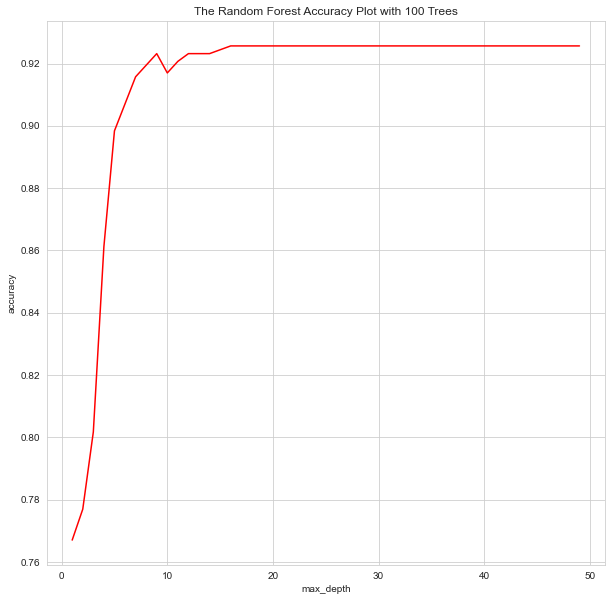

In [66]:
sns.set_style("whitegrid")
plt.figure(figsize = (10, 10))
ax = sns.lineplot(x="max_depth", y="accuracy", color = 'red', data=df_accuracy3)
ax.set_title('The Random Forest Accuracy Plot with 100 Trees')
plt.show()

In [38]:
fruit_test = []
test_labels = []
for i in range(len(test_fruit5)):
    images = cv2.imread(test_fruit5['path_fruit'][i], cv2.IMREAD_COLOR)
    images = cv2.resize(images, (60, 60))
    images = cv2.cvtColor(images, cv2.COLOR_RGB2BGR)    
    fruit_test.append(images)
    test_labels.append(test_fruit5['label'][i])
    
fruit_test = np.array(fruit_test)

In [39]:
#creating labels for images
test_labels = np.array(test_labels)
test_label2 = {j:i for i,j in enumerate(np.unique(test_labels))}
test_label_ids = np.array([test_label2[x] for x in test_labels])

In [40]:
test_scaled = scaler.transform([i.flatten() for i in fruit_test])
test_pca = pca.transform(test_scaled)

In [41]:
df_test_pca = DataFrame()
for i in range(5):
    df_test_pca[i] = test_pca[:,i]
df_test_pca.head()

,0,1,2,3,4
0,15.350870,-8.072800,17.383211,25.088388,13.687021
1,45.630300,1.587237,6.047166,-8.615700,12.505697
2,20.734466,21.308707,3.264857,-32.261218,26.689930
3,17.888723,24.009895,3.548745,-30.862216,25.389524
4,34.690474,-4.384195,17.050167,25.593011,6.034348


In [42]:
X_train = df_pca
X_test = df_test_pca
y_train = label_ids
y_test = test_label_ids

In [67]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
precision = (accuracy_score(test_label_ids, y_pred))*100
print("The accuracy of KNN model is: {0:.2f}%".format(precision))

The accuracy of KNN model is: 97.65%


In [78]:
dtree = DecisionTreeClassifier(max_depth = 9)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
precision = accuracy_score(y_pred, y_test)*100
print("The accuracy of Decision Tree model is: {0:.2f}%".format(precision))

The accuracy of Decision Tree model is: 88.23%


In [108]:
rf = RandomForestClassifier(max_depth = 16)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = accuracy_score(y_pred, y_test)*100
print("The accuracy of Random Forest model is: {0:.2f}%".format(precision))

The accuracy of Random Forest model is: 92.57%
